# TaP spin-orbit coupling effects

In [1]:
from scipy.constants import e, h, mega
from wien2k.core import Wien2kParse
from nqr.core import Efg
import os
import os.path as op
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

def make_equal_axes_scales(axs, axis):
    get_lim_methods = {'x': matplotlib.axes.Axes.get_xlim, 'y': matplotlib.axes.Axes.get_ylim}
    set_lim_methods = {'x': matplotlib.axes.Axes.set_xlim, 'y': matplotlib.axes.Axes.set_ylim}
    get_xylim = get_lim_methods[axis]
    set_xylim = set_lim_methods[axis]
    
    ax_range_max = 0
    for i, ax in enumerate(axs):
        ax_range = np.ptp(get_xylim(ax))
        if ax_range > ax_range_max:
            ax_range_max = ax_range
    
    for i, ax in enumerate(axs):
        ax_range = np.ptp(get_xylim(ax))
        if ax_range < ax_range_max:
            ax_diff = ax_range_max - ax_range
            ax_min = get_xylim(ax)[0] - ax_diff/2
            ax_max = get_xylim(ax)[1] + ax_diff/2
            set_xylim(ax, ax_min, ax_max)

# Turning on spin-orbit effects in WIEN2k

* run to self-consistency as regular calculation
* save the calculation with `save_lapw`
* initialize spin-orbit calculation with `init_so`; accept all defaults except experiment with `emax` parameter (consider adding relativistic local orbitals (RLOs) for heavy atoms)
* run to self-consistency with `-so` flag

In [2]:
mat = 'TaP'
site = 'Ta1'

## See how `rkmax` changes with SOC calculation at `emax=5.0`.
Increase `emax` to include more eigenvalues for basis

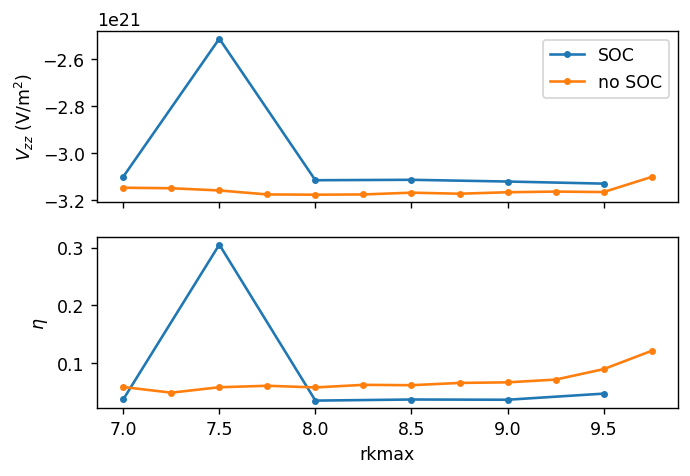

In [3]:
Vzz, Vzz_nrel = np.zeros(6), np.zeros(12)
eta, eta_nrel = np.zeros(6), np.zeros(12)
rkmax, rkmax_nrel = np.zeros(6), np.zeros(12)
for i, val in enumerate(np.arange(7, 10, 0.5)):
    w2k = Wien2kParse(fr'../../data/raw/TaP/TaP/convergence/soc/5/{val}/TaP/')
    Vzz[i], eta[i] = w2k.efg[site].Vzz, w2k.efg[site].eta
    rkmax[i] = val
for i, val in enumerate(np.arange(7, 10, 0.25)):
    w2k = Wien2kParse(fr'../../data/raw/TaP/TaP/convergence/rkmax/{val}/TaP/')
    Vzz_nrel[i], eta_nrel[i] = w2k.efg[site].Vzz, w2k.efg[site].eta
    rkmax_nrel[i] = val
fig, (ax1, ax2) = plt.subplots(2, sharex=True, dpi=125)
ax1.plot(rkmax, Vzz, '.-', label='SOC');
ax1.plot(rkmax_nrel, Vzz_nrel, '.-', label='no SOC');
ax1.set(ylabel='$V_{zz}$ (V/m$^2)$');
ax2.plot(rkmax, eta, '.-', label='SOC');
ax2.plot(rkmax_nrel, eta_nrel, '.-', label='no SOC');
ax2.set(xlabel='rkmax', ylabel='$\eta$');
ax1.legend();

## Now try varying `emax`

First extract data

In [4]:
path = '../../data/raw/TaP/TaP/convergence/soc'
emax_dirs = np.sort(os.listdir(path))
rkmax_dirs = np.sort(np.array(next(os.walk(op.join(path, emax_dirs[0])))[1]))
efg = Efg(site, mat, V=np.zeros((rkmax_dirs.size, emax_dirs.size, 3)))
efg_nrel = Efg(site, mat, V=np.zeros((rkmax_dirs.size, 1, 3)))
for i, ed in enumerate(emax_dirs):
    emax_path = op.join(path, ed)
    for j, rd in enumerate(rkmax_dirs):
        if i == 0:
            wien_dir = op.join(emax_path, rd, mat + '_nrel')
            w2k = Wien2kParse(wien_dir)
            efg_nrel.V[j, i, :] = w2k.efg[site].V
        wien_dir = op.join(emax_path, rd, mat)
        w2k = Wien2kParse(wien_dir)
        efg.V[j, i, :] = w2k.efg[site].V
exp = -1*1e21*Efg(mat, site, V=[-0.865, -2.139, 3.004])
fplo = -1*1e21*Efg(mat, site, V=[-1.186, -2.354, 3.540])
#vasp = 1e20*Efg(mat, site, V=[2.081, 20.328, -22.409]) # T_pv potentials used
vasp = 1e20*Efg(mat, site, V=[8.878, 21.595, -30.472]) # T_sv potentials used

Plot EFG PA componenets vs. `rkmax`

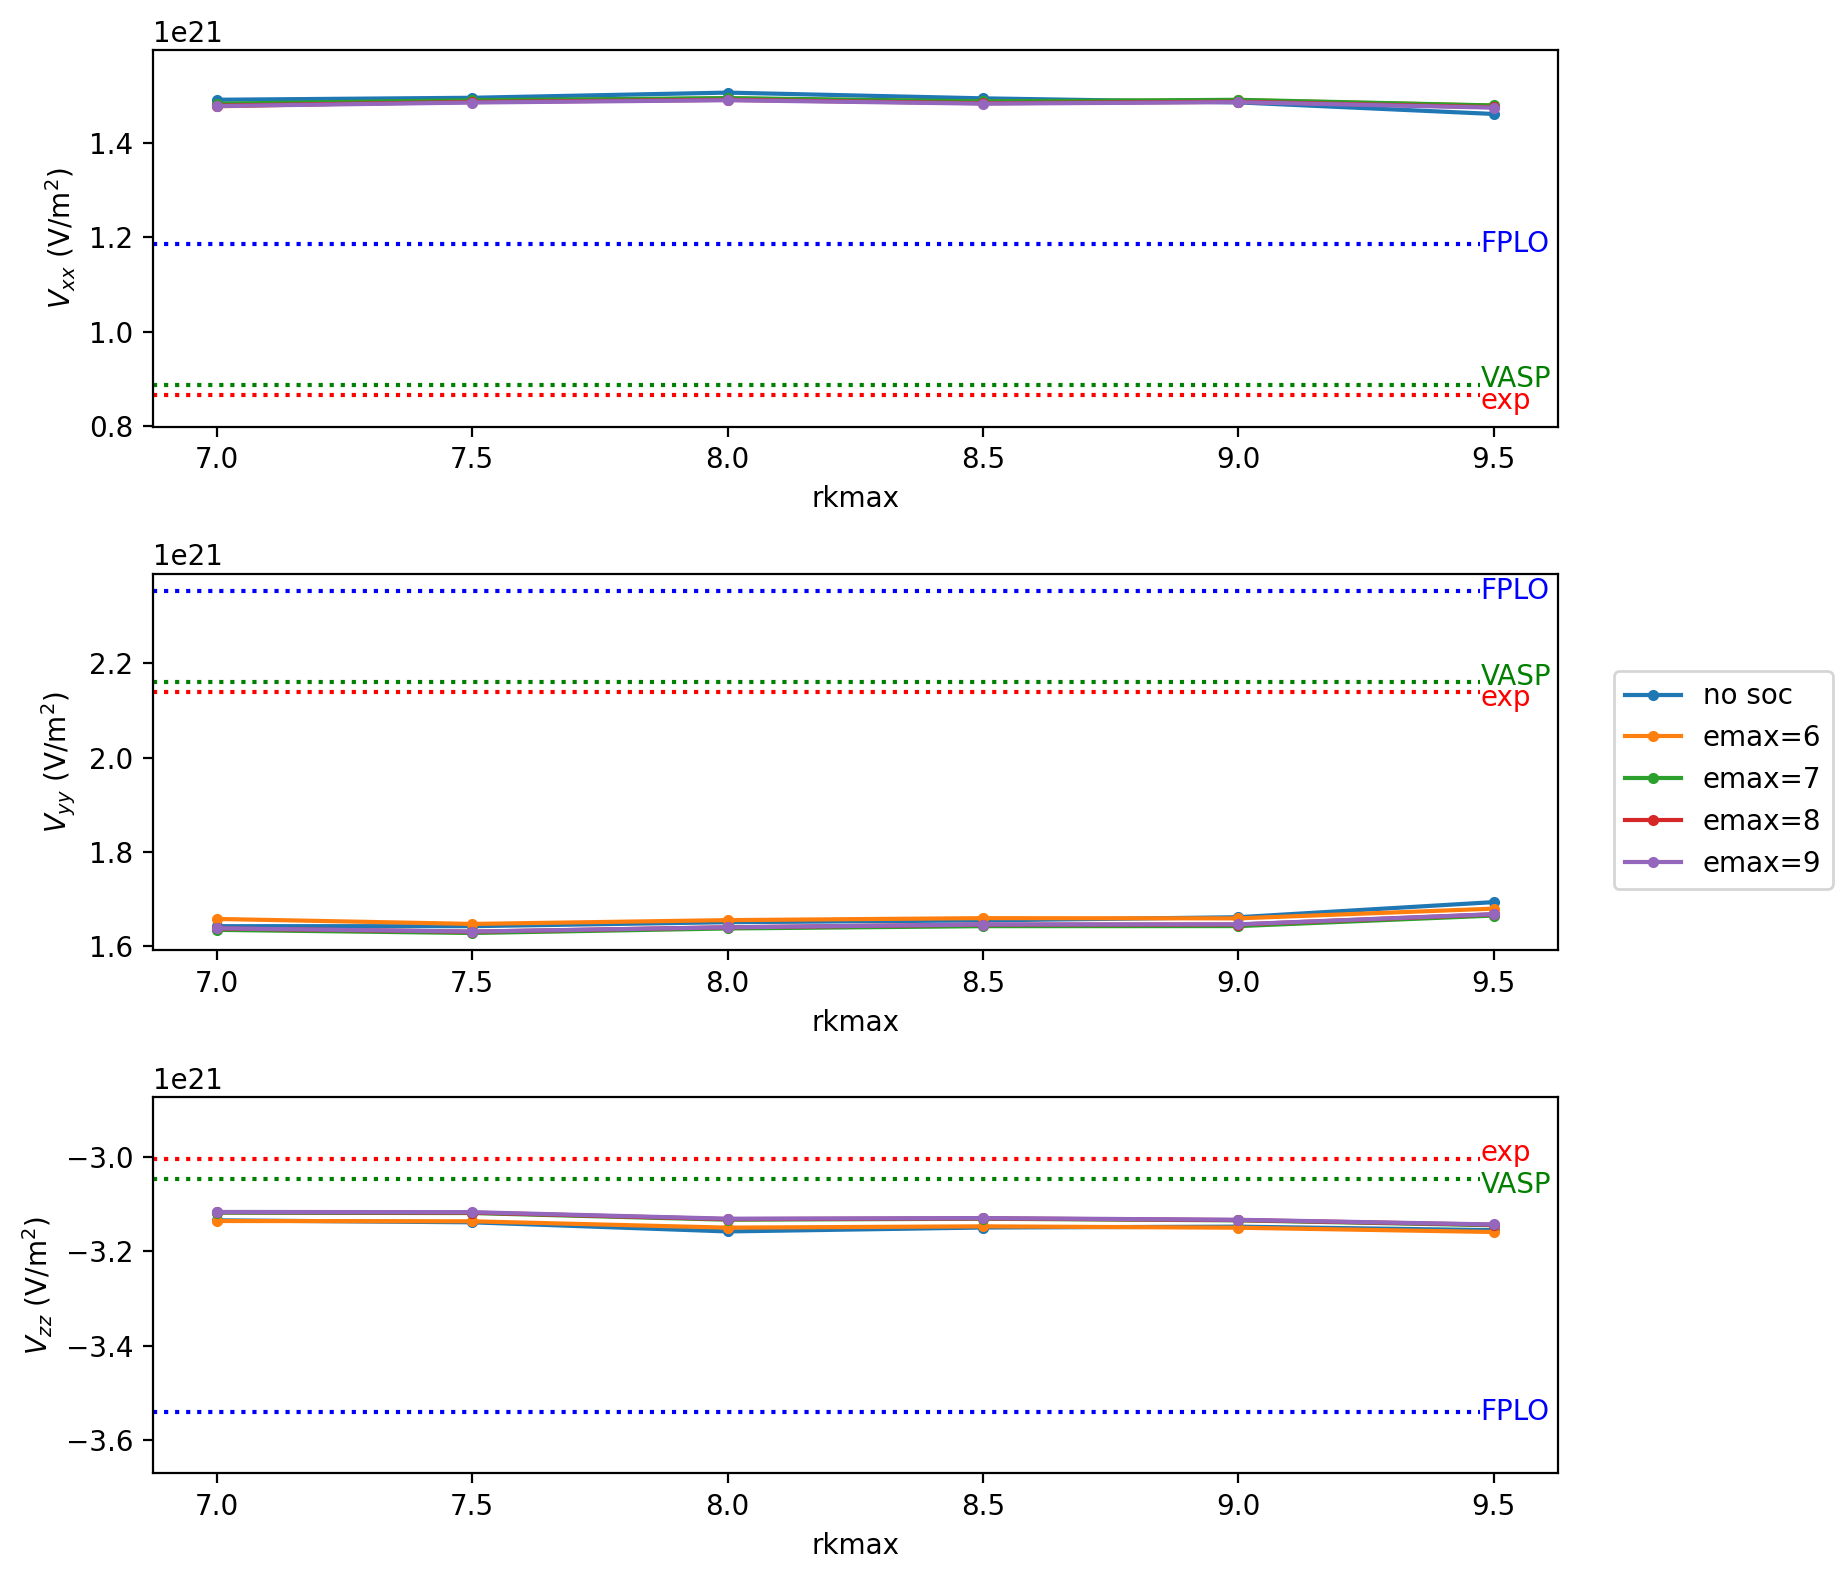

In [5]:
fig, axs = plt.subplots(3, figsize=(8,8), sharex=False, dpi=200)
s = 4
emax_vals = emax_dirs[s:]
an_pos = {}
an_pos['fplo'] = [(0.945, fplo.Vxx), (0.945, fplo.Vyy), (0.945, fplo.Vzz)]
an_pos['vasp'] = [(0.945, vasp.Vxx+0.0125e21), (0.945, vasp.Vyy+0.0125e21), (0.945, vasp.Vzz-0.0125e21)]
an_pos['exp'] = [(0.945, exp.Vxx-0.0125e21), (0.945, exp.Vyy-0.01235e21), (0.945, exp.Vzz+0.0125e21)]
an_color = {}
an_color['fplo'], an_color['vasp'], an_color['exp'],  = 'b', 'g', 'r'
for i in range(3):
    axs[i].plot(rkmax_dirs, efg_nrel.V[:, 0, i], '.-', label='no soc')
    for j, ed in enumerate(emax_vals):
        j += s
        label = f'emax={ed}'
        axs[i].plot(rkmax_dirs, efg.V[:, j, i], '.-', label=label)
    for method in ['FPLO', 'VASP', 'exp']:
        m = method.lower()
        axs[i].axhline(eval(m).V[i], xmax=an_pos[m][0][0], color=an_color[m], linestyle=':')
        axs[i].annotate(method, an_pos[m][i], color=an_color[m], xycoords=("axes fraction", "data"), va='center')
    axs[i].set(xlabel='rkmax', ylabel=f'{ {i} } (V/m$^2$)'.format('$V_{xx}$', '$V_{yy}$', '$V_{zz}$'))

make_equal_axes_scales(axs[0:3], 'y')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()  
fig.savefig('TaP_efg_plot.pdf', bbox_inches='tight')

Conclusion: no appreciable effect from SOC.